# Transpiler: Qiskit vs Quantastica

## Prerequisites:

Install Quantastica QPS API by uncommenting this line:

In [21]:
# !pip install quantastica-qps-api

Fore details see: https://pypi.org/project/quantastica-qps-api/

**You need to run following only once on this system** and then remove the cell - don't keep your API key in notebook.

Uncomment following two lines, add your API key and run:

In [22]:
# from quantastica.qps_api import QPS

# QPS.save_account("YOUR_API_TOKEN")

## When input is circuit:


Input circuit:

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
id q[2];
ch q[0],q[1];
ccx q[2],q[0],q[1];
crz(1.8541792) q[0],q[1];
tdg q[2];



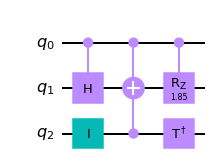


Qiskit transpile:

Depth: 16
Ops: 20
CNOTs: 9


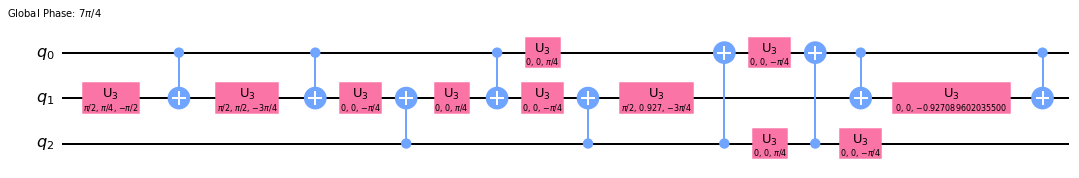


Quantastica transpile:

Depth: 16
Ops: 18
CNOTs: 9


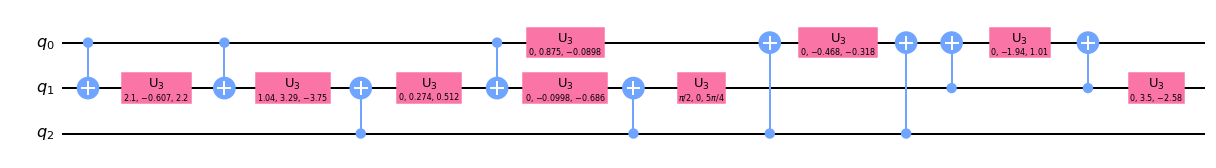

In [23]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.compiler import transpile
from qiskit.quantum_info import Operator


from quantastica.qps_api import QPS

gates = ["id", "u3", "cx"]
#gates = ["id", "rz", "sx", "x", "cx"]

#
# Generate random circuit
#
print("")
print("Input circuit:")

NUM_QUBITS=3
seed=None
input_qc = random_circuit(NUM_QUBITS, 3, measure=False, seed=seed)
input_qasm = input_qc.qasm()

print("")
print(input_qasm)
display(input_qc.draw(output="mpl"))

#
# Qiskit transpile
#
print("")
print("Qiskit transpile:")

qiskit_qc = transpile(input_qc, basis_gates=gates, optimization_level=3)

print("")
print("Depth:", qiskit_qc.depth())
print("Ops:", sum(j for i, j in qiskit_qc.count_ops().items()))
print("CNOTs:", qiskit_qc.count_ops()["cx"] if "cx" in qiskit_qc.count_ops() else 0)

#print(qiskit_qc.qasm())
display(qiskit_qc.draw(output="mpl"))

#
# Quantastica transpile
#
print("")
print("Quantastica transpile:")

job_id = QPS.generator.transpile(input_qasm, method="replace_blocks", method_options={ "block_size": 2, "two_pass": False }, settings = { "instruction_set": gates, "pre_processing": "experimental1", "diff_method": "ignorephase" })

job = QPS.generator.get_job(job_id, wait=True)
job_status = job["status"]
job_output = job["output"]
if(job_status == "error"):
    raise Exception(job_output["message"])

if(len(job_output["circuits"]) == 0):
    raise Exception("No solution")

transpiled_circuit = job_output["circuits"][0]

transpiled_qasm = transpiled_circuit["qasm"]
transpiled_qc = QuantumCircuit.from_qasm_str(transpiled_qasm)

print("")
print("Depth:", transpiled_qc.depth())
print("Ops:", sum(j for i, j in transpiled_qc.count_ops().items()))
print("CNOTs:", transpiled_qc.count_ops()["cx"] if "cx" in transpiled_qc.count_ops() else 0)

#print(transpiled_qasm)
display(transpiled_qc.draw(output="mpl"))


## When input is unitary matrix:


Depth: 15
Ops: 24
CNOTs: 7


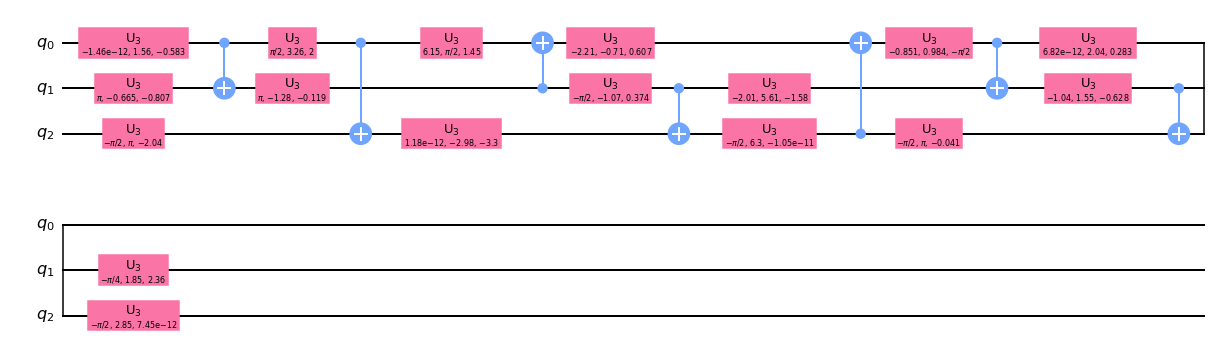

In [24]:
#
# For comparison with previous method, we take original random circuit's unitary as input 
#

input_unitary = Operator(input_qc).data.tolist()

#print(repr(unitary))

job_id = QPS.generator.decompose_unitary(input_unitary, settings = { "instruction_set": gates, "strategy": "strategy_a", "pre_processing": "experimental5", "single_solution": True })

job = QPS.generator.get_job(job_id, wait=True)

job_status = job["status"]
job_output = job["output"]
if(job_status == "error"):
    raise Exception(job_output["message"])

decomposed_circuit = job_output["circuits"][0]
decomposed_qasm = decomposed_circuit["qasm"]
decomposed_qc = QuantumCircuit.from_qasm_str(decomposed_qasm)

print("")
print("Depth:", decomposed_qc.depth())
print("Ops:", sum(j for i, j in decomposed_qc.count_ops().items()))
print("CNOTs:", decomposed_qc.count_ops()["cx"] if "cx" in decomposed_qc.count_ops() else 0)
display(decomposed_qc.draw(output="mpl"))
